<a href="https://colab.research.google.com/github/esnue/ThesisAllocationSystem/blob/main/contextualized_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


adapted from: https://github.com/MilaNLProc/contextualized-topic-models

## Contextualized Topic Models 

We are going to use contextualized topic modeling to get topics out of a supervisors' academic papers, student proposals and supervision plans.

## Topic Models 

Topic models allow you to discover latent topics in text documents in a completely unsupervised way. 

## Contextualized Topic Models

What are Contextualized Topic Models? **CTMs** are a family of topic models that combine the expressive power of BERT embeddings with the unsupervised capabilities of topic models to get topics out of documents.




# Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

# Installing Contextualized Topic Models

Now, we install the contextualized topic model library

In [1]:
%%capture
!pip install contextualized-topic-models==1.8.1
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

## Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

#academic papers
file1 = pd.read_csv("/content/drive/MyDrive/ThesisAllocationSystem/data_final/train-papers-final.csv")
#transform content column row values into a list
train_file = file1['Content'][1:].values.tolist()

print(train_file[5])
print(type(train_file))

#thesis proposals
file2 = pd.read_csv("/content/drive/MyDrive/ThesisAllocationSystem/data_final/test-proposals-final.csv")
test_file = file2['Content'][1:].values.tolist()

print(test_file[2])
print(type(test_file))

#supervision plans
file3 = pd.read_csv("/content/drive/MyDrive/ThesisAllocationSystem/data_final/supervisors-final.csv")
val_file = file3['Content'][1:].values.tolist()

print(val_file[5])
print(type(val_file))

b"Public Administration Reform in Europe  \n\nViews and Experiences from Senior Executives in 10 Countries \n\n \nWP3 Cross-national Report as part of the COCOPS Research Project \n\n \n\n  \n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nGerhard Hammerschmid \nSteven Van de Walle \n\nRhys Andrews \nPhilippe Bezes \nAnja G\xf6rnitz \nAnca Oprisor \n\nVid timac \n\n \n\nJuly 2013 \n\n \n\n \n\n \n\n \n\n \n\nCoordination for Cohesion in the Public Sector of the Future (COCOPS): www.cocops.eu \n\n  \n\n \n\nhttp://www.cocops.eu/\n\n\nCOCOPS Work Package 3  Cross-national Report, July 2013 Page 2 \n\nAbout COCOPS \n\nThe COCOPS project (Coordinating for Cohesion in the Public Sector of the Future) seeks to \n\ncomparatively and quantitatively assess the impact of New Public Management-style reforms in \n\nEuropean countries, drawing on a team of European public administration scholars from 11 \n\nuniversities in 10 countries. It analyses the impact of reforms i

## Importing what we need

For some reasons it gives an error when the cell runs at first time, just try again and it should work.

In [5]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_list, TopicModelDataPreparation
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models import ldamodel 
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk
import os
import pickle

## Preprocessing

Let's pass our file with preprocess data to our text handler object. This object takes care of creating the bag of words for you.

Why do we use the **preprocessed text** here? we need text without punctuation to build the bag of word. Also, we might want only to have the most frequent words inside the BoW. Too many words might not help.

#### Train data

In [6]:
nltk.download('stopwords')

documents = train_file
#documents = [line.strip() for line in open(text_file, encoding="utf-8").readlines()]
sp = WhiteSpacePreprocessing(documents, "english")
train_preprocessed_documents_for_bow, train_unpreprocessed_corpus_for_contextual, vocab = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Test data

In [7]:
documents = test_file
#documents = [line.strip() for line in open(text_file, encoding="utf-8").readlines()]
sp = WhiteSpacePreprocessing(documents, "english")
test_preprocessed_documents_for_bow, test_unpreprocessed_corpus_for_contextual, vocab = sp.preprocess()

### Validation Data

In [8]:
documents = val_file
#documents = [line.strip() for line in open(text_file, encoding="utf-8").readlines()]
sp = WhiteSpacePreprocessing(documents, "english")
val_preprocessed_documents_for_bow, val_unpreprocessed_corpus_for_contextual, vocab = sp.preprocess()

You might want to pickle the **training_dataset** object to avoid recomputing the BoW multiple times

In [9]:
qt = TopicModelDataPreparation("bert-base-nli-mean-tokens")

training_dataset = qt.create_training_set(train_unpreprocessed_corpus_for_contextual, train_preprocessed_documents_for_bow)

100%|██████████| 405M/405M [00:24<00:00, 16.7MB/s]


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
#pickle the training dataset
with open('training.pickle', 'wb') as f:
    pickle.dump(training_dataset, f)

## Training our Contextualized Topic Model

Finally, we can fit our new topic model. We will ask the model to find 28 topics in our collection (n_component parameter of the CTM object), equal to number of supervisors

In [11]:
ctm = CombinedTM(input_size=len(qt.vocab), bert_input_size=768, n_components=28, num_epochs=20)

ctm.fit(training_dataset) 

Epoch: [20/20]	 Seen Samples: [16200/16200]	Train Loss: 13033.494290123457	Time: 0:00:00.387779: : 20it [00:07,  2.59it/s]


## Saving the Model

In [12]:
path = F"/content/drive/MyDrive/ThesisAllocationSystem/models/ctm.bin" 
ctm.save(path)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/models/ctm.py:388: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  Warning)


## Loading the Model 

In [ ]:
#del ctm

Q HANNAH: how to open saved model

In [ ]:
#ctm = CombinedTM(input_size=len(qt.vocab), bert_input_size=768, num_epochs=100, n_components=50)

#ctm.load("/content/drive/MyDrive/ThesisAllocationSystem/models/ctm.bin/contextualized_topic_model_nc_25_tpm_0.0_tpv_0.96_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/epoch_14.pth", epoch = 14)

Loading from Colab directory doesn't seem to work. 

# Topics

After training, now it is the time to look at our topics: we can use the 

```
get_topic_lists
```

function to get the topics. It also accepts a parameter that allows you to select how many words you want to see for each topic.

If you look at the topics, you will see that they all make sense and are representative of a collection of documents that comes from Wikipedia (general knowledge).

In [14]:
ctm.get_topic_lists(20)

[['data',
  'used',
  'et',
  'al',
  'results',
  'different',
  'energy',
  'nd',
  'using',
  'nn',
  'one',
  'value',
  'use',
  'two',
  'model',
  'party',
  'large',
  'ns',
  'analysis',
  'nin'],
 ['distinguish',
  'phenomenon',
  'closer',
  'get',
  'seek',
  'causes',
  'wider',
  'remained',
  'mail',
  'horizontal',
  'added',
  'effectively',
  'attempts',
  'indicates',
  'inclusion',
  'body',
  'furthermore',
  'distributed',
  'affects',
  'earlier'],
 ['states',
  'european',
  'eu',
  'member',
  'making',
  'actors',
  'decision',
  'nthe',
  'international',
  'legitimacy',
  'see',
  'state',
  'process',
  'journal',
  'council',
  'asylum',
  'union',
  'central',
  'political',
  'core'],
 ['germany',
  'german',
  'education',
  'fertility',
  'higher',
  'birth',
  'low',
  'women',
  'employment',
  'power',
  'market',
  'time',
  'study',
  'high',
  'kreyenfeld',
  'training',
  'age',
  'family',
  'system',
  'level'],
 ['government',
  'political',


We see that most topics are coherent, however the input data needs further cleaning during preprocessing, to avoid topics such as `['nu', 'nn', 'nm', 'na', 'ne']`

### Let's find our documents' topics

Ok now we can take a document and see which topic has been asigned to it. Results will obviously change with respect to the documents you are using. For example, let's predict the topic of the first preprocessed document.

In [24]:
topics_predictions = ctm.get_doc_topic_distribution(training_dataset, n_samples=20) # get all the topic predictions

array([[0.01577941, 0.01985348, 0.00950735, ..., 0.034477  , 0.03437557,
        0.03375748],
       [0.00491125, 0.19862895, 0.00410378, ..., 0.00671453, 0.00933267,
        0.00760665],
       [0.00710162, 0.00816241, 0.0148982 , ..., 0.03847799, 0.0513298 ,
        0.03427094],
       ...,
       [0.03092527, 0.02049915, 0.04270892, ..., 0.03363015, 0.04208795,
        0.01618558],
       [0.01175864, 0.01497844, 0.03490946, ..., 0.01981825, 0.01961549,
        0.02873682],
       [0.02214756, 0.01380935, 0.06567344, ..., 0.03097284, 0.02318731,
        0.02864021]])

In [16]:
train_preprocessed_documents_for_bow[0] # see the text of the first preprocessed document

'nsee discussions author publication https www researchgate net publication incentive preferences issues strategies local government first evidence narticle authors including nsome authors publication also working related projects open innovative governments view project public sector future view project publications nsee profile school governance publications nsee profile nall content following page september nthe user downloaded nhttps www researchgate net publication motivation incentive preferences issues strategies local government first evidence austria enrichid rgreq xxx enrichsource el esc publicationcoverpdf nhttps www researchgate net publication motivation incentive preferences issues strategies local government first evidence austria enrichid rgreq xxx enrichsource el esc publicationcoverpdf nhttps www researchgate net project open innovative governments enrichid rgreq xxx enrichsource el esc publicationcoverpdf nhttps www researchgate net project public sector future enric

In [17]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) # get the topic id of the first document
topic_number

11

In [19]:
ctm.get_topic_lists(20)[topic_number] #and the topic should and could be about public management related things

['public',
 'government',
 'political',
 'state',
 'actors',
 'central',
 'institutions',
 'making',
 'policy',
 'sector',
 'organizations',
 'organizational',
 'institutional',
 'autonomy',
 'civil',
 'nand',
 'literature',
 'capacity',
 'media',
 'administration']

### Visualization of a topic

We can visualize `topic 11`, which is our first document's topic id. We want the wordcloud to display 20 words of the topic.

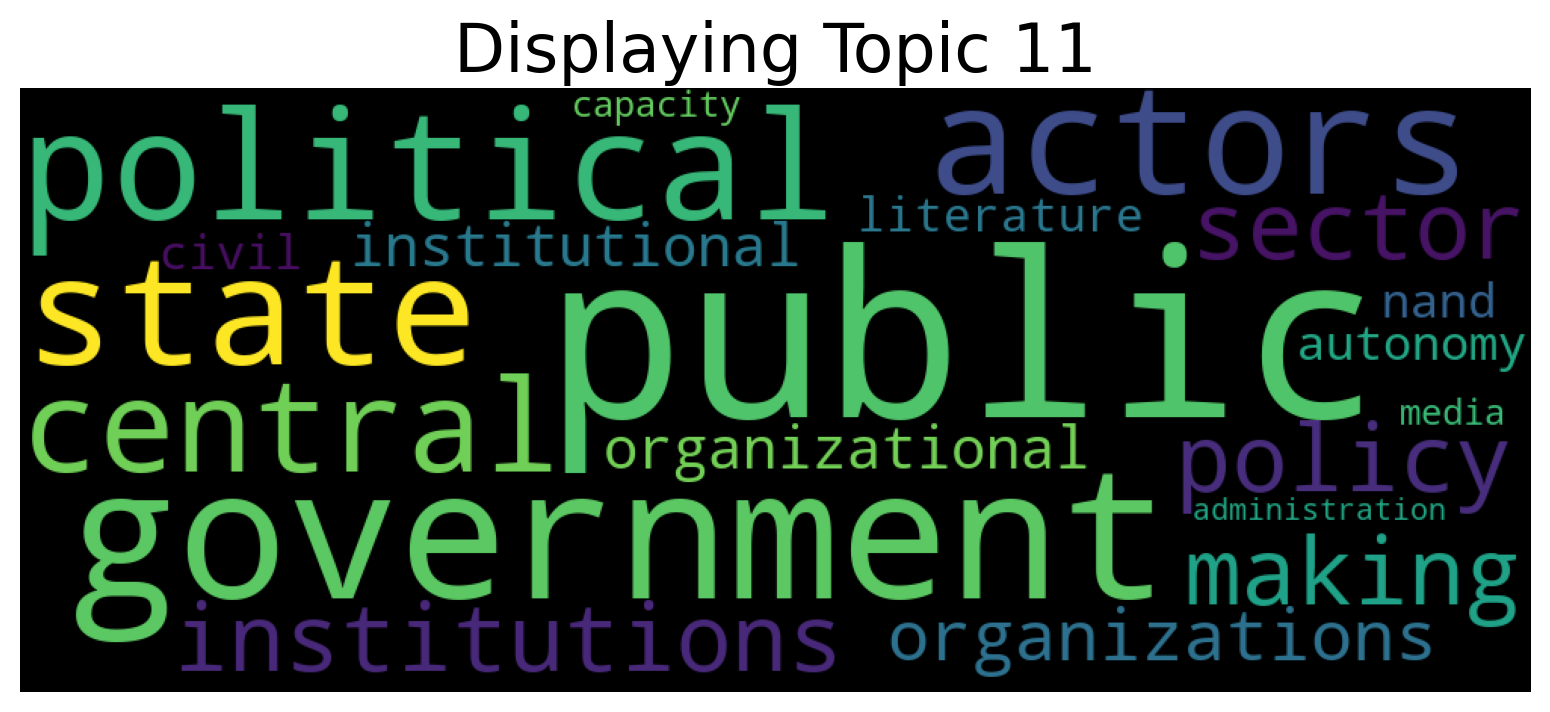

In [20]:
ctm.get_wordcloud(topic_id=11, n_words=20)

In [36]:
print(type(topics_predictions))
print(len(topics_predictions))


#workaround, number of test files available
docs =  list(range(810))

topic_id = []
topic_labels = []
#get all topic ids for each document in the train data set
for doc in docs: 
    topic_index = np.argmax(topics_predictions[doc])
    topic_id.append(topic_index)
    topic = ctm.get_topic_lists(20)[topic_index]
    topic_labels.append(topic)

#this list contains the topic ids for all test documents
topic_id
print(len(topic_id))
# this list contains the labels for all test documents given their respective topic id
topic_labels

810


We are using the created topics with each 20 words to contain test data content, but without the inherent bias coming from writing style and word choice. Furthermore, we use the topic ids as labels which we then plan to input into a distilBERT classifier model. 

In [51]:
import pandas as pd

train_label_df = pd.DataFrame()

train_label_df["topic_id"] = topic_id
train_label_df["topic"] = topic_labels
train_label_df

train_label_df.to_csv('/content/drive/MyDrive/ThesisAllocationSystem/data_final/ctm_label/train-label.csv', index = False)

## Test

We are using the test set to predict for unseen documents. 

In [58]:
testing_dataset = qt.create_test_set(test_unpreprocessed_corpus_for_contextual, test_preprocessed_documents_for_bow) # create dataset for the testset
predictions = ctm.get_doc_topic_distribution(testing_dataset, n_samples=10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling: [10/10]: : 10it [00:01,  5.88it/s]


In [59]:
print(test_unpreprocessed_corpus_for_contextual[3])

topic_index = np.argmax(predictions[3])
ctm.get_topic_lists(20)[topic_index]

b'Thesis Proposal \n\nCitizen Perceptions and Preferences on Hate Speech Declaration and Hate Speech \n\nRegulations \n\nJoshita Pai \n\nSona Jose \n\nIntroduction \n\nWhile its effect is disputably unquantifiable, targeted anti-Semitic attacks on Jewish journalists \n\nand the stirring of ethnic conflicts in Myanmar are attributable to sustained bouts of offensive \n\nspeech circulated online.   \n\nFrom triggering polarization to creating riot-like situations (Arun et al., 2016), Governments \n\nacross the world regard hate speech as outside the bounds of free speech and insist digital \n\nplatform providers to evaluate their community standards and to prevent the spread of online \n\nhate speech. The larger emphasis has been on the policies by respective governments and \n\nplatform regulations. However, this research project is an attempt to understand citizen \n\npreferences in terms of online hate speech regulation and also their perceptions regarding what \n\nessentially constit

['attempt',
 'team',
 'nsee',
 'closer',
 'distinguish',
 'narticle',
 'nresults',
 'ngovernments',
 'analyze',
 'nwork',
 'descriptive',
 'causes',
 'requirements',
 'seek',
 'cycle',
 'explained',
 'tool',
 'comments',
 'gives',
 'publicly']

Topics seem to show mixed validity here, might be due to shortness of the proposal text as well as the small sample size. Hopefully this will improve

In [61]:
print(type(topics_predictions))
#print(topics_predictions)

print(len(test_file))

#workaround, number of test files available
docs =  list(range(6))

topic_id = []
topic_labels = []
#get all topic ids for each document in the test data set
for doc in docs: 
    topic_index = np.argmax(topics_predictions[doc])
    topic_id.append(topic_index)
    topic = ctm.get_topic_lists(20)[topic_index]
    topic_labels.append(topic)

#this list contains the topic ids for all test documents
topic_id
# this list contains the labels for all test documents given their respective topic id
topic_labels


<class 'numpy.ndarray'>
5


[['public',
  'government',
  'political',
  'state',
  'actors',
  'central',
  'institutions',
  'making',
  'policy',
  'sector',
  'organizations',
  'organizational',
  'institutional',
  'autonomy',
  'civil',
  'nand',
  'literature',
  'capacity',
  'media',
  'administration'],
 ['attempt',
  'team',
  'nsee',
  'closer',
  'distinguish',
  'narticle',
  'nresults',
  'ngovernments',
  'analyze',
  'nwork',
  'descriptive',
  'causes',
  'requirements',
  'seek',
  'cycle',
  'explained',
  'tool',
  'comments',
  'gives',
  'publicly'],
 ['organizations',
  'social',
  'sector',
  'institutional',
  'training',
  'actors',
  'nonprofit',
  'vet',
  'public',
  'new',
  'institutions',
  'education',
  'governance',
  'vocational',
  'different',
  'research',
  'management',
  'service',
  'germany',
  'work'],
 ['public',
  'government',
  'political',
  'state',
  'actors',
  'central',
  'institutions',
  'making',
  'policy',
  'sector',
  'organizations',
  'organization

In [62]:
test_label_df = pd.DataFrame()

#test_label_df['text'] = file2['Content']
test_label_df["topic_id"] = topic_id
test_label_df["topic"] = topic_labels
test_label_df

test_label_df.to_csv('/content/drive/MyDrive/ThesisAllocationSystem/data_final/ctm_label/test-label.csv', index = False)

## Validation

We are using the supervision plans to predict for topics that professors offer their students to write their thesis about.

In [63]:
validation_dataset = qt.create_test_set(val_unpreprocessed_corpus_for_contextual, val_preprocessed_documents_for_bow) # create dataset for the test set
predictions = ctm.get_doc_topic_distribution(validation_dataset, n_samples=10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling: [5/5]: : 5it [00:00,  5.71it/s]


In [64]:
print(val_unpreprocessed_corpus_for_contextual[4])

topic_index = np.argmax(predictions[3])
ctm.get_topic_lists(20)[topic_index]

b'MIA/MPP - Supervision Plan AY2020/2021        1 \n\n \n \n\nMaster Thesis Supervision Plan \nAcademic Year 2020-2021 \n\nMIA/MPP \n \n\nName: Thurid Hustedt  \n\nProfessor of Public Administration and Management \n\n  \nAdvisor Information  \n\nOffice 3.12.1 \n\nE-Mail hustedt@hertie-school.org \n\nFaculty Assistant Jonida Popi, popi@hertie-school.org \n\nOffice Hours Please make an appointment by email \n\n \n \nResearch & Advising Profile: \nGeneral Academic Field: What is your academic field, and what are your areas of supervision? \n\nMy general academic field is public administration, public management and public policy.  \n\n \n\n \n\n \n\n \n\n \n\nSpecific Expertise: What is your specific area of expertise, and what topics are you supervising? \n\nMy research focusses on politico-administrative relations, public sector change dynamics and \n\ncomparative public administration. I am interested in structures and processes of government \n\ncoordination, decision-making and poli

['nsee',
 'crossmark',
 'ties',
 'resulting',
 'frequently',
 'team',
 'ngovernments',
 'call',
 'nresults',
 'successful',
 'tool',
 'collected',
 'seem',
 'comparing',
 'analyze',
 'look',
 'systematically',
 'gives',
 'professor',
 'comments']

Again, little topic validity, worse than with test data. Probably due to shortness of relevant text

# Evaluation

In [65]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI

#with train_preprocessed_documents_for_bow as fr:
texts = [line.split() for line in train_preprocessed_documents_for_bow] # load text for NPMI

npmi = CoherenceNPMI(texts=texts, topics=ctm.get_topic_lists(10))
npmi.score()

0.03651266930787447

# Perform Matching